In [1]:
# Clone the ibm/tsfm
! git clone --depth 1 --branch v0.2.9 https://github.com/IBM/tsfm.git

Cloning into 'tsfm'...
Note: switching to 'f856e5bfc739dc23b2a2dace13bbe3b45d21ceee'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



In [1]:
!uv pip install numpy==1.26.4 --force-reinstall
import numpy as np
print(np.__version__)

Resolved 1 package in 122ms
Prepared 1 package in 0.81ms
Installed 1 package in 1.04s
 + numpy==1.26.4


1.26.4


In [2]:
# Change directory. Move inside the tsfm repo.
%cd tsfm

c:\Users\prakh\Desktop\Research_Project\LLM\tsfm


c:\Users\prakh\Desktop\Research_Project\LLM\.venv\lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
%%capture
# Install the tsfm library
! uv pip install ".[notebooks]"

%cd ../

In [4]:
!uv pip install scikit-learn
     

Audited 1 package in 41ms


In [5]:
!uv pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu128

Resolved 13 packages in 5.85s
Prepared 3 packages in 7m 23s
Uninstalled 1 package in 4.06s
Installed 3 packages in 13.18s
 - torch==2.7.1
 + torch==2.7.1+cu128
 + torchaudio==2.7.1+cu128
 + torchvision==0.22.1+cu128


In [1]:
# Standard
import os
import math
import tempfile
import torch

# Third Party
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
import numpy as np
import pandas as pd

# Local
from tsfm.tsfm_public.models.tinytimemixer import TinyTimeMixerForPrediction
from tsfm.tsfm_public.toolkit.callbacks import TrackingCallback

In [83]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)

# Results dir
OUT_DIR = "ttm_finetuned_models/"

# TTM model branch
# Use main for 512-96 model
# Use "1024_96_v1" for 1024-96 model
TTM_MODEL_REVISION = "main"

# Forecasting parameters
context_length = 512
forecast_length = 96
fewshot_fraction = 0.02

In [84]:
import pandas as pd

# Load the uploaded Fengyun-2F dataset
df = pd.read_csv("Fengyun_2F.csv")

# Display the first few rows to understand the structure
df.head()


,Unnamed: 0,eccentricity,argument of perigee,inclination,mean anomaly,Brouwer mean motion,right ascension
0,2012-09-06 18:48:32.050655,0.000488,4.483911,0.032940,-2.689729,0.004374,4.842139
1,2012-09-07 19:39:45.383327,0.000487,4.481215,0.032901,-2.446726,0.004374,4.842234
2,2012-09-08 15:43:39.075167,0.000487,4.475122,0.032868,-3.457326,0.004374,4.842332
3,2012-09-09 12:53:36.595967,0.000492,4.481063,0.032835,-4.190783,0.004374,4.842201
4,2012-09-10 13:15:22.135391,0.000495,4.512943,0.032798,-4.111348,0.004374,4.842257


In [85]:
# Rename the timestamp column
df = df.rename(columns={"Unnamed: 0": "timestamp"})

# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])

# Define columns
timestamp_column = "timestamp"
target_columns = ["eccentricity"]
observable_columns = [
    "argument of perigee",
    "inclination",
    "mean anomaly",
    "Brouwer mean motion",
    "right ascension"
]

# Set context/prediction lengths
context_length = 512      # how many past steps to consider
forecast_length = 96     # how many future steps to predict

# Determine split points
data_length = len(df)
train_end_index = round(data_length * 0.8)
eval_start_index = train_end_index - context_length
eval_end_index = round(data_length * 0.9)
test_start_index = eval_end_index - context_length
test_end_index = data_length

# Build split config
split_config = {
    "train": [0, train_end_index],
    "valid": [eval_start_index, eval_end_index],
    "test": [test_start_index, test_end_index],
}

# Column specifiers
column_specifiers = {
    "timestamp_column": timestamp_column,
    "target_columns": target_columns,
    "observable_columns": observable_columns
}

# Prepare TimeSeriesPreprocessor
from tsfm_public import TimeSeriesPreprocessor, get_datasets

tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=context_length,
    prediction_length=forecast_length,
    scaling=True,
    encode_categorical=False,
    scaler_type="minmax",
)

# Create datasets
train_dataset, valid_dataset, test_dataset = get_datasets(
    tsp, df, split_config
)

# Print result sizes
len(train_dataset), len(valid_dataset), len(test_dataset)


c:\Users\prakh\Desktop\Research_Project\LLM\.venv\lib\site-packages\tsfm_public\toolkit\time_series_preprocessor.py:674: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df.groupby(id_columns, group_keys=False).apply(
c:\Users\prakh\Desktop\Research_Project\LLM\.venv\lib\site-packages\tsfm_public\toolkit\time_series_preprocessor.py:674: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df.groupby(id_column

(1781, 715, 716)

In [86]:
zeroshot_model = TinyTimeMixerForPrediction.from_pretrained("ibm/TTM", revision="main", prediction_filter_length=24)

# zeroshot_trainer
zeroshot_trainer = Trainer(
    model=zeroshot_model,
)

zeroshot_trainer.evaluate(test_dataset)

{'eval_loss': 0.026784567162394524,
 'eval_model_preparation_time': 0.0055,
 'eval_runtime': 1.0221,
 'eval_samples_per_second': 700.516,
 'eval_steps_per_second': 88.054}

In [87]:
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.time_series_forecasting_pipeline import TimeSeriesForecastingPipeline
from tsfm_public.toolkit.visualization import plot_ts_forecasting

test_data = tsp.preprocess(df[test_start_index:test_end_index])

zs_forecast_pipeline = TimeSeriesForecastingPipeline(
    model=zeroshot_model,
    device="cuda",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    freq="1h"
)

c:\Users\prakh\Desktop\Research_Project\LLM\.venv\lib\site-packages\tsfm_public\toolkit\time_series_preprocessor.py:674: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df.groupby(id_columns, group_keys=False).apply(
Device set to use cuda


In [88]:
zs_forecast = zs_forecast_pipeline(test_data)

In [89]:
def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):
  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons
     

In [90]:
out

,timestamp,actual,pred,anomaly
0,2021-02-02 10:09:03.665376,0.138099,0.132863,0
1,2021-02-03 11:59:27.670847,0.139147,0.133239,0
2,2021-02-04 04:51:46.500191,0.138343,0.132761,0
3,2021-02-05 00:42:42.737183,0.138029,0.131520,0
4,2021-02-06 01:51:34.235711,0.137749,0.132985,0
...,...,...,...,...
294,2021-12-21 17:34:42.607776,0.109647,0.107477,0
295,2021-12-25 04:39:15.108767,0.118350,0.109485,0
296,2021-12-28 21:00:18.080928,0.178644,0.117607,1
297,2022-01-06 13:25:24.541247,0.180496,0.144412,0


In [107]:
zs_forecast["eccentricity"]

0      [0.1380985677242279, 0.13914714753627777, 0.13...
1      [0.13914714753627777, 0.1383432298898697, 0.13...
2      [0.1383432298898697, 0.13802866637706757, 0.13...
3      [0.13802866637706757, 0.13774904608726501, 0.1...
4      [0.13774904608726501, 0.1390073448419571, 0.13...
                             ...                        
295    [0.11835023015737534, 0.1786438375711441, 0.18...
296    [0.1786438375711441, 0.18049633502960205, 0.16...
297    [0.18049633502960205, 0.16997553408145905, nan...
298    [0.16997553408145905, nan, nan, nan, nan, nan,...
299    [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...
Name: eccentricity, Length: 300, dtype: object

In [108]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve, auc

actual = []
pred = []
hours_out=12


for i in range(len(zs_forecast)):
    pred.append(zs_forecast["eccentricity_prediction"].values[i][hours_out - 1]) # prediction for next day
    actual.append(zs_forecast["eccentricity"].values[i][hours_out - 1])

#preds = zs_forecast.loc[0]['eccentricity_prediction'][:24]
#actuals = zs_forecast.loc[0]['eccentricity'][:24]
preds = np.array(pred)
actuals = np.array(actual)


In [122]:
valid_mask = ~np.isnan(actuals) & ~np.isnan(preds)
actuals = actuals[valid_mask]
preds = preds[valid_mask]

pred_time=zs_forecast['timestamp']

start_time = zs_forecast['timestamp'].iloc[0]
forecast_start = start_time + pd.Timedelta("28H")
pred_time = pd.date_range(start=forecast_start, periods=len(preds), freq="28H")
#time=pred_time

#time = time[valid_mask]

C:\Users\prakh\AppData\Local\Temp\ipykernel_51600\550500354.py:8: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  forecast_start = start_time + pd.Timedelta("28H")
C:\Users\prakh\AppData\Local\Temp\ipykernel_51600\550500354.py:9: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  pred_time = pd.date_range(start=forecast_start, periods=len(preds), freq="28H")


In [94]:
print("Shapes:")
print("actuals:", actuals.shape)
print("preds:", preds.shape)
print("pred_time:", pred_time.shape)
print("time:", time.shape)

Shapes:
actuals: (288,)
preds: (288,)
pred_time: (288,)
time: (288,)


In [95]:
residuals = actuals - preds
residuals = residuals[~np.isnan(residuals)]
# Example: consider top 10% largest residuals as anomalies (for ROC calculation only)
threshold_percentile = 90
dynamic_threshold = np.percentile(residuals, threshold_percentile)

labels = (residuals > dynamic_threshold).astype(int)
fpr, tpr, thresholds = roc_curve(labels, residuals)
roc_auc = auc(fpr, tpr)

threshold_percentile = 0.1


dynamic_threshold = np.percentile(residuals, 0.1)
anomaly_labels = (residuals > dynamic_threshold).astype(int)

print(dynamic_threshold)
print(fpr, tpr, thresholds)

-0.06879923333972693
[0. 0. 0. 1.] [0.         0.03448276 1.         1.        ] [        inf  0.07632242  0.02595934 -0.07060932]


In [96]:
precision, recall, _ = precision_recall_curve(anomaly_labels, residuals)
pr_auc = auc(recall, precision)
print(pr_auc)

1.0


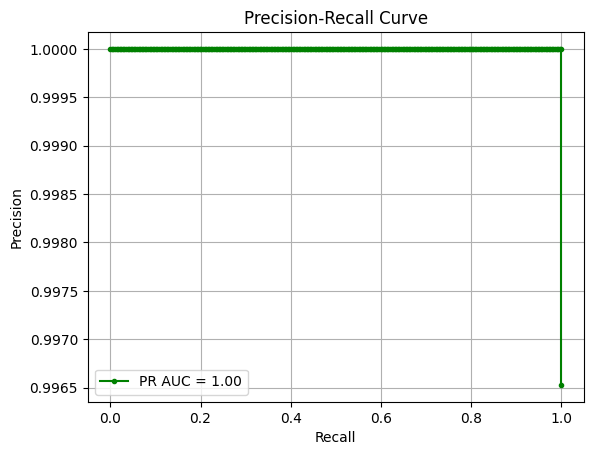

In [97]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(recall, precision, marker='.', color='green', label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()

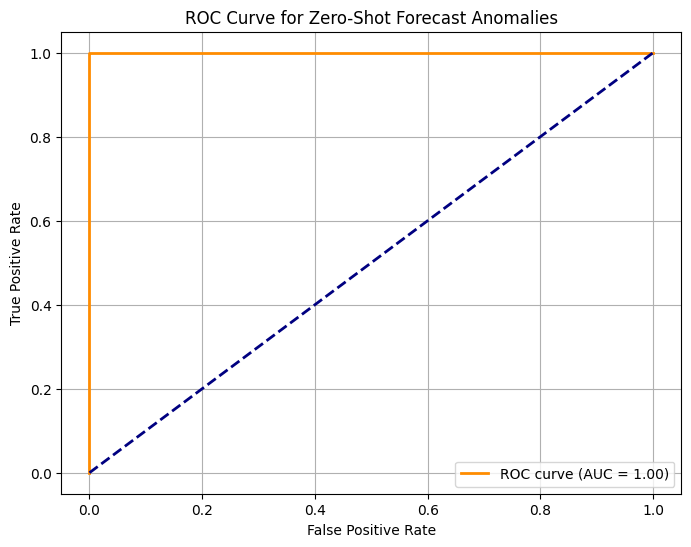

In [98]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Zero-Shot Forecast Anomalies")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [99]:
# Youden's J statistic (tpr - fpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for anomaly classification: {best_threshold:.4f}")
anomaly_labels = (residuals > best_threshold).astype(int)

Best threshold for anomaly classification: 0.0260


Confusion Matrix:
 [[278   0]
 [  1  20]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       278
     Anomaly       1.00      0.95      0.98        21

    accuracy                           1.00       299
   macro avg       1.00      0.98      0.99       299
weighted avg       1.00      1.00      1.00       299



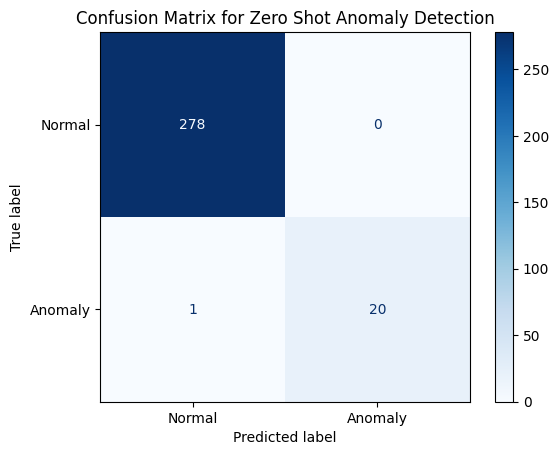

In [ ]:

# Youden's J statistic (tpr - fpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for anomaly classification: {best_threshold:.4f}")
anomaly_labels = (residuals > best_threshold).astype(int)

one_day_out_predictions = compare_forecast(zs_forecast, "timestamp", "eccentricity_prediction", "eccentricity",1)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]


residuals = np.abs(out['actual'] - out['pred'])


out['anomaly'] = (residuals > best_threshold).astype(int)
anomalies = out[out['anomaly'] == 1]


precision, recall, _ = precision_recall_curve(out['anomaly'] , residuals)
pr_auc = auc(recall, precision)
print(pr_auc)


fpr, tpr, thresholds = roc_curve(out['anomaly'], residuals)
roc_auc = auc(fpr, tpr)

# Youden's J statistic (tpr - fpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]
anomaly_labels = (residuals > best_threshold).astype(int)


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Compute confusion matrix
cm = confusion_matrix(out['anomaly'], anomaly_labels)
print("Confusion Matrix:\n", cm)

# Optional: pretty display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Also print classification metrics
print(classification_report(out['anomaly'], anomaly_labels, target_names=["Normal", "Anomaly"]))


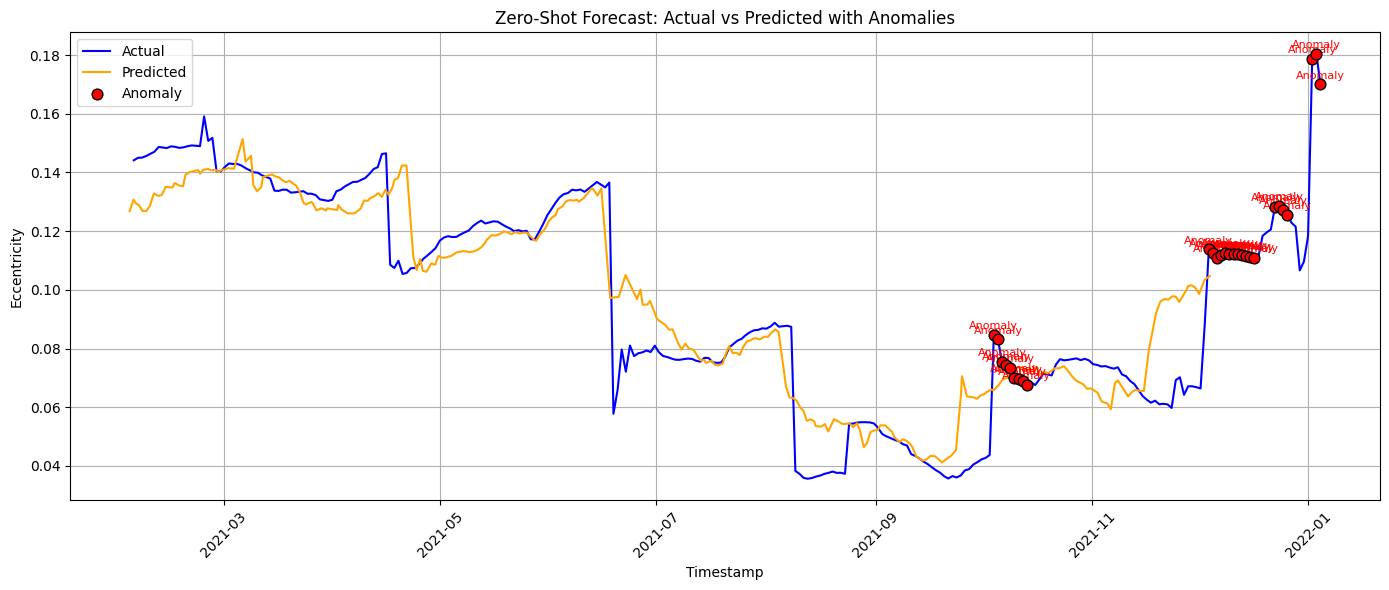

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 6))
plt.plot(pred_time, actuals, label='Actual', color='blue')
plt.plot(time, preds, label='Predicted', color='orange')
plt.scatter(
    pred_time[anomaly_labels == 1],
    actuals[anomaly_labels == 1],
    color='red', label='Anomaly', zorder=5, s=60, edgecolors='black'
)

for x, y in zip(pred_time[anomaly_labels == 1],actuals[anomaly_labels == 1]):
    plt.text(x, y + 0.002, 'Anomaly', color='red', fontsize=8, ha='center')
plt.legend()

plt.xlabel("Timestamp")
plt.ylabel("Eccentricity")
plt.title("Zero-Shot Forecast: Actual vs Predicted with Anomalies")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [37]:
finetune_forecast_model = TinyTimeMixerForPrediction.from_pretrained(
    "ibm/TTM", revision=TTM_MODEL_REVISION, prediction_filter_length=24
)

In [38]:
# Freeze the backbone of the model
for param in finetune_forecast_model.backbone.parameters():
    param.requires_grad = False 

In [39]:

# Important parameters
learning_rate = 0.001
num_epochs = 100
batch_size = 64

finetune_forecast_args = TrainingArguments(
    output_dir=os.path.join(OUT_DIR, "output"),
    overwrite_output_dir=True,
    learning_rate=learning_rate,
    num_train_epochs=num_epochs,
    do_eval=True,
    eval_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    #dataloader_num_workers=8,
    report_to=None,
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=1,
    logging_dir=os.path.join(OUT_DIR, "logs"),  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=10,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.001,  # Minimum improvement required to consider as improvement
)
tracking_callback = TrackingCallback()

# Optimizer and scheduler
optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
scheduler = OneCycleLR(
    optimizer,
    learning_rate,
    epochs=num_epochs,
    steps_per_epoch=math.ceil(len(train_dataset) / (batch_size)),
)

finetune_forecast_trainer = Trainer(
    model=finetune_forecast_model,
    args=finetune_forecast_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback, tracking_callback],
    optimizers=(optimizer, scheduler),
)

# Fine tune
finetune_forecast_trainer.train()

Epoch,Training Loss,Validation Loss
1,0.020500,0.029004
2,0.020000,0.028498
3,0.019600,0.028084
4,0.019300,0.027672
5,0.019000,0.027200
6,0.018600,0.026775
7,0.018300,0.026396
8,0.018000,0.026116
9,0.017700,0.025979
10,0.017500,0.025740


[TrackingCallback] Mean Epoch Time = 0.5436401150443337 seconds, Total Train Time = 7.924073219299316


TrainOutput(global_step=308, training_loss=0.01870711167137344, metrics={'train_runtime': 7.9262, 'train_samples_per_second': 22469.739, 'train_steps_per_second': 353.258, 'total_flos': 290787664527360.0, 'train_loss': 0.01870711167137344, 'epoch': 11.0})

In [40]:
finetune_forecast_trainer.evaluate(test_dataset)

{'eval_loss': 0.024010449647903442,
 'eval_runtime': 0.1224,
 'eval_samples_per_second': 5848.669,
 'eval_steps_per_second': 98.022,
 'epoch': 11.0}

In [41]:
test_data = tsp.preprocess(df[test_start_index:test_end_index])

c:\Users\prakh\Desktop\Research_Project\LLM\.venv\lib\site-packages\tsfm_public\toolkit\time_series_preprocessor.py:674: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_out = df.groupby(id_columns, group_keys=False).apply(


In [42]:
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=finetune_forecast_model,
    device="cpu",
    timestamp_column=timestamp_column,
    id_columns=[],
    target_columns=target_columns,
    observable_columns=observable_columns,
    freq="1h"
)
context_length = finetune_forecast_model.config.context_length

Device set to use cpu


In [43]:
forecasts = forecast_pipeline(test_data)

1.0
Best threshold for anomaly classification: 0.0610


C:\Users\prakh\AppData\Local\Temp\ipykernel_51600\855514414.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out['anomaly'] = (residuals > best_threshold).astype(int)


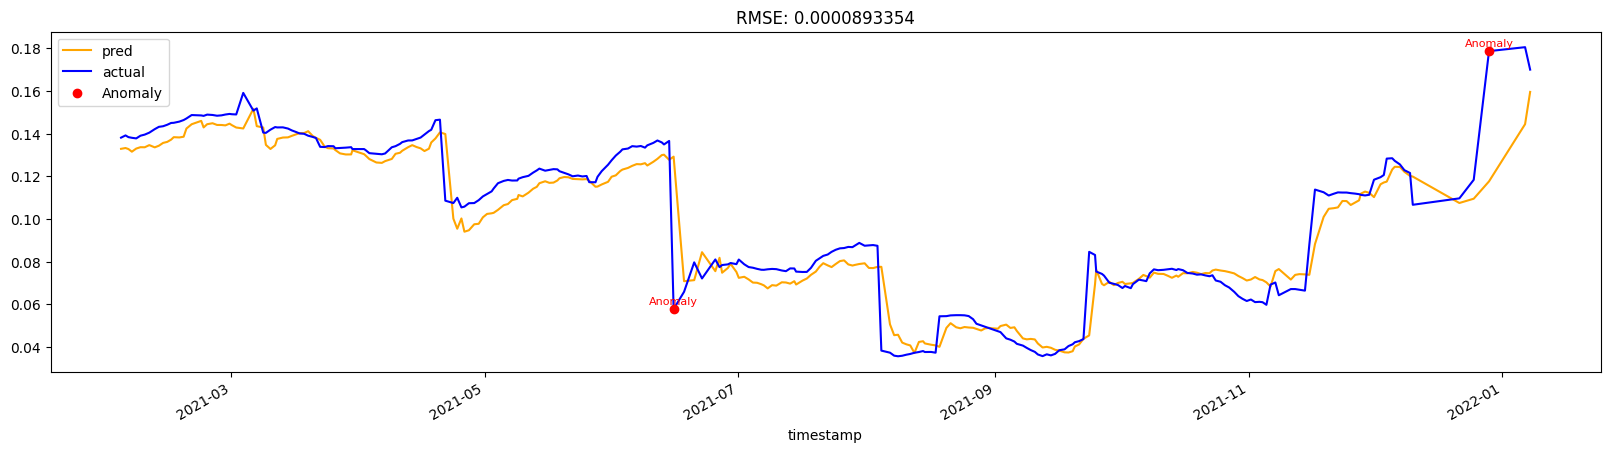

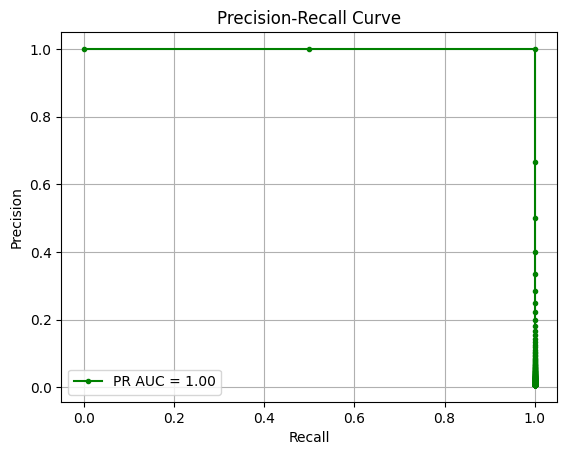

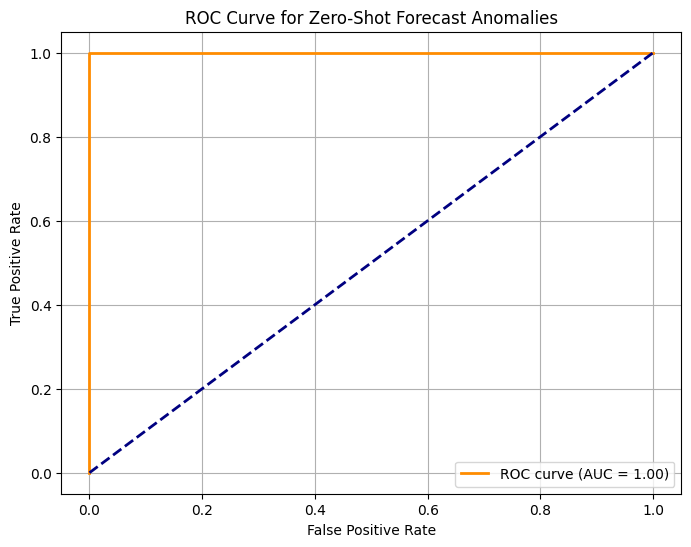

In [82]:
one_day_out_predictions = compare_forecast(forecasts, "timestamp", "eccentricity_prediction", "eccentricity",1)

out = one_day_out_predictions[[not np.isnan(x).any() for x in one_day_out_predictions['actual']]]


residuals = np.abs(out['actual'] - out['pred'])


out['anomaly'] = (residuals > best_threshold).astype(int)
anomalies = out[out['anomaly'] == 1]


precision, recall, _ = precision_recall_curve(out['anomaly'] , residuals)
pr_auc = auc(recall, precision)
print(pr_auc)


fpr, tpr, thresholds = roc_curve(out['anomaly'], residuals)
roc_auc = auc(fpr, tpr)

# Youden's J statistic (tpr - fpr)
j_scores = tpr - fpr
best_idx = np.argmax(j_scores)
best_threshold = thresholds[best_idx]

print(f"Best threshold for anomaly classification: {best_threshold:.4f}")
anomaly_labels = (residuals > best_threshold).astype(int)


ax = out.plot(x="timestamp", y=["pred", "actual"],color=["orange", "blue"], figsize=(20, 5), title="RMSE: " + str(rms))
ax.scatter(anomalies['timestamp'], anomalies['actual'], color='red', label='Anomaly', zorder=5)
for x, y in zip(anomalies['timestamp'], anomalies['actual']):
    ax.text(x, y + 0.002, 'Anomaly', color='red', fontsize=8, ha='center')
ax.legend()


import matplotlib.pyplot as plt

plt.figure()
plt.plot(recall, precision, marker='.', color='green', label=f"PR AUC = {pr_auc:.2f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Zero-Shot Forecast Anomalies")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()




#rms = '{:.10f}'.format(mean_squared_error(out['actual'], out['pred'])).plot(x="timestamp", y=["pred", "actual"], figsize=(20,5), title="RMSE:" + str(rms))
#one_day_out_predictions

Confusion Matrix:
 [[294   0]
 [  1   4]]
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00       294
     Anomaly       1.00      0.80      0.89         5

    accuracy                           1.00       299
   macro avg       1.00      0.90      0.94       299
weighted avg       1.00      1.00      1.00       299



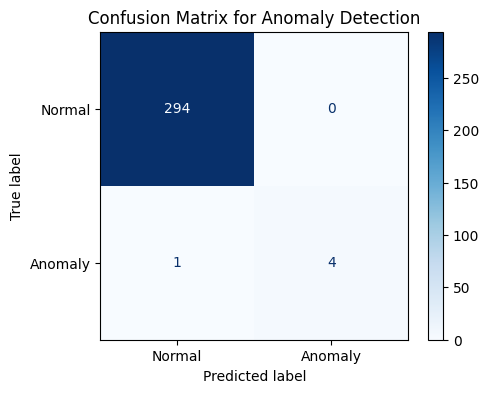

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

# Compute confusion matrix
cm = confusion_matrix(out['anomaly'], anomaly_labels)
print("Confusion Matrix:\n", cm)

# Optional: pretty display
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Anomaly"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for Anomaly Detection")
plt.show()

# Also print classification metrics
print(classification_report(out['anomaly'], anomaly_labels, target_names=["Normal", "Anomaly"]))
